# Reward distributions

In [1]:
from huggingface_hub import hf_hub_download, HfApi
from plotnine import ggplot, aes, geom_density, scale_fill_manual, xlim
from skopt import load
from stable_baselines3 import PPO

from rl4fisheries import AsmEnv, FMsy, ConstantEscapement, PrecautionaryPrinciple
from rl4fisheries.utils import evaluate_agent
from rl4fisheries.envs.asm_fns import get_r_devs

import numpy as np
import pandas as pd
import ray

In [2]:
_viridis_data = [[0.267004, 0.004874, 0.329415],
                 [0.268510, 0.009605, 0.335427],
                 [0.269944, 0.014625, 0.341379],
                 [0.271305, 0.019942, 0.347269],
                 [0.272594, 0.025563, 0.353093],
                 [0.273809, 0.031497, 0.358853],
                 [0.274952, 0.037752, 0.364543],
                 [0.276022, 0.044167, 0.370164],
                 [0.277018, 0.050344, 0.375715],
                 [0.277941, 0.056324, 0.381191],
                 [0.278791, 0.062145, 0.386592],
                 [0.279566, 0.067836, 0.391917],
                 [0.280267, 0.073417, 0.397163],
                 [0.280894, 0.078907, 0.402329],
                 [0.281446, 0.084320, 0.407414],
                 [0.281924, 0.089666, 0.412415],
                 [0.282327, 0.094955, 0.417331],
                 [0.282656, 0.100196, 0.422160],
                 [0.282910, 0.105393, 0.426902],
                 [0.283091, 0.110553, 0.431554],
                 [0.283197, 0.115680, 0.436115],
                 [0.283229, 0.120777, 0.440584],
                 [0.283187, 0.125848, 0.444960],
                 [0.283072, 0.130895, 0.449241],
                 [0.282884, 0.135920, 0.453427],
                 [0.282623, 0.140926, 0.457517],
                 [0.282290, 0.145912, 0.461510],
                 [0.281887, 0.150881, 0.465405],
                 [0.281412, 0.155834, 0.469201],
                 [0.280868, 0.160771, 0.472899],
                 [0.280255, 0.165693, 0.476498],
                 [0.279574, 0.170599, 0.479997],
                 [0.278826, 0.175490, 0.483397],
                 [0.278012, 0.180367, 0.486697],
                 [0.277134, 0.185228, 0.489898],
                 [0.276194, 0.190074, 0.493001],
                 [0.275191, 0.194905, 0.496005],
                 [0.274128, 0.199721, 0.498911],
                 [0.273006, 0.204520, 0.501721],
                 [0.271828, 0.209303, 0.504434],
                 [0.270595, 0.214069, 0.507052],
                 [0.269308, 0.218818, 0.509577],
                 [0.267968, 0.223549, 0.512008],
                 [0.266580, 0.228262, 0.514349],
                 [0.265145, 0.232956, 0.516599],
                 [0.263663, 0.237631, 0.518762],
                 [0.262138, 0.242286, 0.520837],
                 [0.260571, 0.246922, 0.522828],
                 [0.258965, 0.251537, 0.524736],
                 [0.257322, 0.256130, 0.526563],
                 [0.255645, 0.260703, 0.528312],
                 [0.253935, 0.265254, 0.529983],
                 [0.252194, 0.269783, 0.531579],
                 [0.250425, 0.274290, 0.533103],
                 [0.248629, 0.278775, 0.534556],
                 [0.246811, 0.283237, 0.535941],
                 [0.244972, 0.287675, 0.537260],
                 [0.243113, 0.292092, 0.538516],
                 [0.241237, 0.296485, 0.539709],
                 [0.239346, 0.300855, 0.540844],
                 [0.237441, 0.305202, 0.541921],
                 [0.235526, 0.309527, 0.542944],
                 [0.233603, 0.313828, 0.543914],
                 [0.231674, 0.318106, 0.544834],
                 [0.229739, 0.322361, 0.545706],
                 [0.227802, 0.326594, 0.546532],
                 [0.225863, 0.330805, 0.547314],
                 [0.223925, 0.334994, 0.548053],
                 [0.221989, 0.339161, 0.548752],
                 [0.220057, 0.343307, 0.549413],
                 [0.218130, 0.347432, 0.550038],
                 [0.216210, 0.351535, 0.550627],
                 [0.214298, 0.355619, 0.551184],
                 [0.212395, 0.359683, 0.551710],
                 [0.210503, 0.363727, 0.552206],
                 [0.208623, 0.367752, 0.552675],
                 [0.206756, 0.371758, 0.553117],
                 [0.204903, 0.375746, 0.553533],
                 [0.203063, 0.379716, 0.553925],
                 [0.201239, 0.383670, 0.554294],
                 [0.199430, 0.387607, 0.554642],
                 [0.197636, 0.391528, 0.554969],
                 [0.195860, 0.395433, 0.555276],
                 [0.194100, 0.399323, 0.555565],
                 [0.192357, 0.403199, 0.555836],
                 [0.190631, 0.407061, 0.556089],
                 [0.188923, 0.410910, 0.556326],
                 [0.187231, 0.414746, 0.556547],
                 [0.185556, 0.418570, 0.556753],
                 [0.183898, 0.422383, 0.556944],
                 [0.182256, 0.426184, 0.557120],
                 [0.180629, 0.429975, 0.557282],
                 [0.179019, 0.433756, 0.557430],
                 [0.177423, 0.437527, 0.557565],
                 [0.175841, 0.441290, 0.557685],
                 [0.174274, 0.445044, 0.557792],
                 [0.172719, 0.448791, 0.557885],
                 [0.171176, 0.452530, 0.557965],
                 [0.169646, 0.456262, 0.558030],
                 [0.168126, 0.459988, 0.558082],
                 [0.166617, 0.463708, 0.558119],
                 [0.165117, 0.467423, 0.558141],
                 [0.163625, 0.471133, 0.558148],
                 [0.162142, 0.474838, 0.558140],
                 [0.160665, 0.478540, 0.558115],
                 [0.159194, 0.482237, 0.558073],
                 [0.157729, 0.485932, 0.558013],
                 [0.156270, 0.489624, 0.557936],
                 [0.154815, 0.493313, 0.557840],
                 [0.153364, 0.497000, 0.557724],
                 [0.151918, 0.500685, 0.557587],
                 [0.150476, 0.504369, 0.557430],
                 [0.149039, 0.508051, 0.557250],
                 [0.147607, 0.511733, 0.557049],
                 [0.146180, 0.515413, 0.556823],
                 [0.144759, 0.519093, 0.556572],
                 [0.143343, 0.522773, 0.556295],
                 [0.141935, 0.526453, 0.555991],
                 [0.140536, 0.530132, 0.555659],
                 [0.139147, 0.533812, 0.555298],
                 [0.137770, 0.537492, 0.554906],
                 [0.136408, 0.541173, 0.554483],
                 [0.135066, 0.544853, 0.554029],
                 [0.133743, 0.548535, 0.553541],
                 [0.132444, 0.552216, 0.553018],
                 [0.131172, 0.555899, 0.552459],
                 [0.129933, 0.559582, 0.551864],
                 [0.128729, 0.563265, 0.551229],
                 [0.127568, 0.566949, 0.550556],
                 [0.126453, 0.570633, 0.549841],
                 [0.125394, 0.574318, 0.549086],
                 [0.124395, 0.578002, 0.548287],
                 [0.123463, 0.581687, 0.547445],
                 [0.122606, 0.585371, 0.546557],
                 [0.121831, 0.589055, 0.545623],
                 [0.121148, 0.592739, 0.544641],
                 [0.120565, 0.596422, 0.543611],
                 [0.120092, 0.600104, 0.542530],
                 [0.119738, 0.603785, 0.541400],
                 [0.119512, 0.607464, 0.540218],
                 [0.119423, 0.611141, 0.538982],
                 [0.119483, 0.614817, 0.537692],
                 [0.119699, 0.618490, 0.536347],
                 [0.120081, 0.622161, 0.534946],
                 [0.120638, 0.625828, 0.533488],
                 [0.121380, 0.629492, 0.531973],
                 [0.122312, 0.633153, 0.530398],
                 [0.123444, 0.636809, 0.528763],
                 [0.124780, 0.640461, 0.527068],
                 [0.126326, 0.644107, 0.525311],
                 [0.128087, 0.647749, 0.523491],
                 [0.130067, 0.651384, 0.521608],
                 [0.132268, 0.655014, 0.519661],
                 [0.134692, 0.658636, 0.517649],
                 [0.137339, 0.662252, 0.515571],
                 [0.140210, 0.665859, 0.513427],
                 [0.143303, 0.669459, 0.511215],
                 [0.146616, 0.673050, 0.508936],
                 [0.150148, 0.676631, 0.506589],
                 [0.153894, 0.680203, 0.504172],
                 [0.157851, 0.683765, 0.501686],
                 [0.162016, 0.687316, 0.499129],
                 [0.166383, 0.690856, 0.496502],
                 [0.170948, 0.694384, 0.493803],
                 [0.175707, 0.697900, 0.491033],
                 [0.180653, 0.701402, 0.488189],
                 [0.185783, 0.704891, 0.485273],
                 [0.191090, 0.708366, 0.482284],
                 [0.196571, 0.711827, 0.479221],
                 [0.202219, 0.715272, 0.476084],
                 [0.208030, 0.718701, 0.472873],
                 [0.214000, 0.722114, 0.469588],
                 [0.220124, 0.725509, 0.466226],
                 [0.226397, 0.728888, 0.462789],
                 [0.232815, 0.732247, 0.459277],
                 [0.239374, 0.735588, 0.455688],
                 [0.246070, 0.738910, 0.452024],
                 [0.252899, 0.742211, 0.448284],
                 [0.259857, 0.745492, 0.444467],
                 [0.266941, 0.748751, 0.440573],
                 [0.274149, 0.751988, 0.436601],
                 [0.281477, 0.755203, 0.432552],
                 [0.288921, 0.758394, 0.428426],
                 [0.296479, 0.761561, 0.424223],
                 [0.304148, 0.764704, 0.419943],
                 [0.311925, 0.767822, 0.415586],
                 [0.319809, 0.770914, 0.411152],
                 [0.327796, 0.773980, 0.406640],
                 [0.335885, 0.777018, 0.402049],
                 [0.344074, 0.780029, 0.397381],
                 [0.352360, 0.783011, 0.392636],
                 [0.360741, 0.785964, 0.387814],
                 [0.369214, 0.788888, 0.382914],
                 [0.377779, 0.791781, 0.377939],
                 [0.386433, 0.794644, 0.372886],
                 [0.395174, 0.797475, 0.367757],
                 [0.404001, 0.800275, 0.362552],
                 [0.412913, 0.803041, 0.357269],
                 [0.421908, 0.805774, 0.351910],
                 [0.430983, 0.808473, 0.346476],
                 [0.440137, 0.811138, 0.340967],
                 [0.449368, 0.813768, 0.335384],
                 [0.458674, 0.816363, 0.329727],
                 [0.468053, 0.818921, 0.323998],
                 [0.477504, 0.821444, 0.318195],
                 [0.487026, 0.823929, 0.312321],
                 [0.496615, 0.826376, 0.306377],
                 [0.506271, 0.828786, 0.300362],
                 [0.515992, 0.831158, 0.294279],
                 [0.525776, 0.833491, 0.288127],
                 [0.535621, 0.835785, 0.281908],
                 [0.545524, 0.838039, 0.275626],
                 [0.555484, 0.840254, 0.269281],
                 [0.565498, 0.842430, 0.262877],
                 [0.575563, 0.844566, 0.256415],
                 [0.585678, 0.846661, 0.249897],
                 [0.595839, 0.848717, 0.243329],
                 [0.606045, 0.850733, 0.236712],
                 [0.616293, 0.852709, 0.230052],
                 [0.626579, 0.854645, 0.223353],
                 [0.636902, 0.856542, 0.216620],
                 [0.647257, 0.858400, 0.209861],
                 [0.657642, 0.860219, 0.203082],
                 [0.668054, 0.861999, 0.196293],
                 [0.678489, 0.863742, 0.189503],
                 [0.688944, 0.865448, 0.182725],
                 [0.699415, 0.867117, 0.175971],
                 [0.709898, 0.868751, 0.169257],
                 [0.720391, 0.870350, 0.162603],
                 [0.730889, 0.871916, 0.156029],
                 [0.741388, 0.873449, 0.149561],
                 [0.751884, 0.874951, 0.143228],
                 [0.762373, 0.876424, 0.137064],
                 [0.772852, 0.877868, 0.131109],
                 [0.783315, 0.879285, 0.125405],
                 [0.793760, 0.880678, 0.120005],
                 [0.804182, 0.882046, 0.114965],
                 [0.814576, 0.883393, 0.110347],
                 [0.824940, 0.884720, 0.106217],
                 [0.835270, 0.886029, 0.102646],
                 [0.845561, 0.887322, 0.099702],
                 [0.855810, 0.888601, 0.097452],
                 [0.866013, 0.889868, 0.095953],
                 [0.876168, 0.891125, 0.095250],
                 [0.886271, 0.892374, 0.095374],
                 [0.896320, 0.893616, 0.096335],
                 [0.906311, 0.894855, 0.098125],
                 [0.916242, 0.896091, 0.100717],
                 [0.926106, 0.897330, 0.104071],
                 [0.935904, 0.898570, 0.108131],
                 [0.945636, 0.899815, 0.112838],
                 [0.955300, 0.901065, 0.118128],
                 [0.964894, 0.902323, 0.123941],
                 [0.974417, 0.903590, 0.130215],
                 [0.983868, 0.904867, 0.136897],
                 [0.993248, 0.906157, 0.143936]]

In [3]:
MWT_OBS_LIST_SHORT = [0, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.9]

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple(rgb)


color_rgbs = [ 
    [255, 43, 0], # 'red',  
    [150, 150, 150], # 'gray',
    [int(255 * datum) for datum in _viridis_data[199]], # 2 obs ppo
    [255,0,255], # 'rose' , 
]

ppo2o_color = color_rgbs[2]
other_colors = [
    [255, 43, 0], # 'red', 
    [114, 171, 216], # light blue
    [150, 150, 150], # 'gray',
    [255,0,255], # 'rose' , 
]

color_hexs = [rgb_to_hex(rgb) for rgb in color_rgbs]

ppo2o_hex = [rgb_to_hex(ppo2o_color)]
other_hexs = [rgb_to_hex(rgb) for rgb in other_colors]


In [4]:
## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}

## Load

In [5]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM1.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM2.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM3.pkl")

esc_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM1.pkl")
esc_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM2.pkl")
esc_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM3.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM1.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM2.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM3.pkl")

In [6]:
cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

esc_UM1 = load(esc_UM1_file)
esc_UM2 = load(esc_UM2_file)
esc_UM3 = load(esc_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [7]:
base_fname = "sb3/rl4fisheries/results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-64-32-16-chkpnt4.zip")
PPO_mw_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM1-64-32-16-chkpnt4.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-chkpnt3.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-64-32-16-chkpnt4.zip")
PPO_mw_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM2-64-32-16-chkpnt2.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-chkpnt2.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-64-32-16-chkpnt4.zip")
PPO_mw_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM3-64-32-16-chkpnt4.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-chkpnt3.zip")

In [8]:
PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_mw_UM1 = PPO.load(PPO_mw_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_mw_UM2 = PPO.load(PPO_mw_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_mw_UM3 = PPO.load(PPO_mw_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

## Reward Plots

In [9]:
def get_rews(agent, env, agent_name):
    rewards = evaluate_agent(
        agent=agent, env=env, ray_remote=True,
    ).evaluate(
        return_episode_rewards=True, n_eval_episodes=500,
    )
    return {'rew': rewards, 'agent': [agent_name] * len(rewards)}

In [10]:
def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}

### UM1

In [11]:
UM1_PPO_2o_rews = get_rews(
    agent=PPO_2o_UM1,
    env=AsmEnv(config=CFG_UM1_2o),
    agent_name='PPO_2o',
)

UM1_PPO_mw_rews = get_rews(
    agent=PPO_mw_UM1,
    env=AsmEnv(config=CFG_UM1_mw),
    agent_name='PPO_mw',
)

UM1_PPO_bm_rews = get_rews(
    agent=PPO_bm_UM1,
    env=AsmEnv(config=CFG_UM1_bm),
    agent_name='PPO_bm',
)


2024-08-20 09:43:22,782	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:43:38,296	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:43:54,357	INFO worker.py:1771 -- Started a local Ray instance.


In [12]:
UM1_CR_rews = get_rews(
    agent=PrecautionaryPrinciple(
        env=AsmEnv(config=CFG_UM1_bm),
        **(from_radius_theta(*cr_UM1.x)),
    ),
    env=AsmEnv(config=CFG_UM1_bm),
    agent_name='CR',
)

UM1_Esc_rews = get_rews(
    agent=ConstantEscapement(
        escapement=esc_UM1.x[0],
        env=AsmEnv(config=CFG_UM1_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM1_bm),
)

UM1_Msy_rews = get_rews(
    agent=FMsy(
        mortality=msy_UM1.x[0],
        env=AsmEnv(config=CFG_UM1_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM1_bm),
)

2024-08-20 09:44:10,564	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:44:18,531	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:44:26,281	INFO worker.py:1771 -- Started a local Ray instance.


In [13]:
ray.shutdown()

In [14]:
## DFO rules!

UM1_msy_step_rew = np.mean(UM1_Msy_rews['rew']) / 1000
UM1_fmsy = msy_UM1.x[0]
UM1_bmsy = UM1_msy_step_rew / UM1_fmsy

UM1_DFO = PrecautionaryPrinciple(
    env=AsmEnv(config=CFG_UM1_bm),
    x1 = 0.4 * UM1_bmsy,
    x2 = 0.8 * UM1_bmsy,
    y2 = UM1_fmsy,
)

UM1_DFO_rews = get_rews(
    agent=UM1_DFO,
    agent_name='DFO',
    env=AsmEnv(config=CFG_UM1_bm),
)


2024-08-20 09:44:34,583	INFO worker.py:1771 -- Started a local Ray instance.


In [15]:
UM1_bmsy

0.98864372624119

In [16]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(UM1_CR_rews),
        pd.DataFrame(UM1_Esc_rews),
        pd.DataFrame(UM1_Msy_rews),
        pd.DataFrame(UM1_DFO_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(UM1_PPO_2o_rews),
        pd.DataFrame(UM1_PPO_mw_rews),
        pd.DataFrame(UM1_PPO_bm_rews),
    ]
)

UM1_results_df = pd.concat(
    [
        pd.DataFrame(UM1_CR_rews), 
        pd.DataFrame(UM1_Msy_rews),  
        pd.DataFrame(UM1_PPO_2o_rews), 
        pd.DataFrame(UM1_PPO_bm_rews),
        pd.DataFrame(UM1_DFO_rews),
    ]
)

In [17]:
print(f"""
UM1:

        mean stdev median
RPP:   {np.mean(UM1_CR_rews['rew']):.2f}, {np.std(UM1_CR_rews['rew']):.2f}, {np.median(UM1_CR_rews['rew']):.2f},
DFO:  {np.mean(UM1_DFO_rews['rew']):.2f}, {np.std(UM1_DFO_rews['rew']):.2f}, {np.median(UM1_DFO_rews['rew']):.2f},
Esc:  {np.mean(UM1_Esc_rews['rew']):.2f}, {np.std(UM1_Esc_rews['rew']):.2f}, {np.median(UM1_Esc_rews['rew']):.2f}, 
FMsy:  {np.mean(UM1_Msy_rews['rew']):.2f}, {np.std(UM1_Msy_rews['rew']):.2f}, {np.median(UM1_Msy_rews['rew']):.2f}, 
PPO2: {np.mean(UM1_PPO_2o_rews['rew']):.2f}, {np.std(UM1_PPO_2o_rews['rew']):.2f}, {np.median(UM1_PPO_2o_rews['rew']):.2f},
PPO1: {np.mean(UM1_PPO_bm_rews['rew']):.2f}, {np.std(UM1_PPO_bm_rews['rew']):.2f}, {np.median(UM1_PPO_bm_rews['rew']):.2f},
""")


UM1:

        mean stdev median
RPP:   105.76, 20.93, 106.13,
DFO:  85.56, 18.40, 84.33,
Esc:  106.33, 22.81, 106.11, 
FMsy:  71.45, 16.87, 70.46, 
PPO2: 98.25, 19.13, 97.42,
PPO1: 99.45, 17.94, 97.98,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


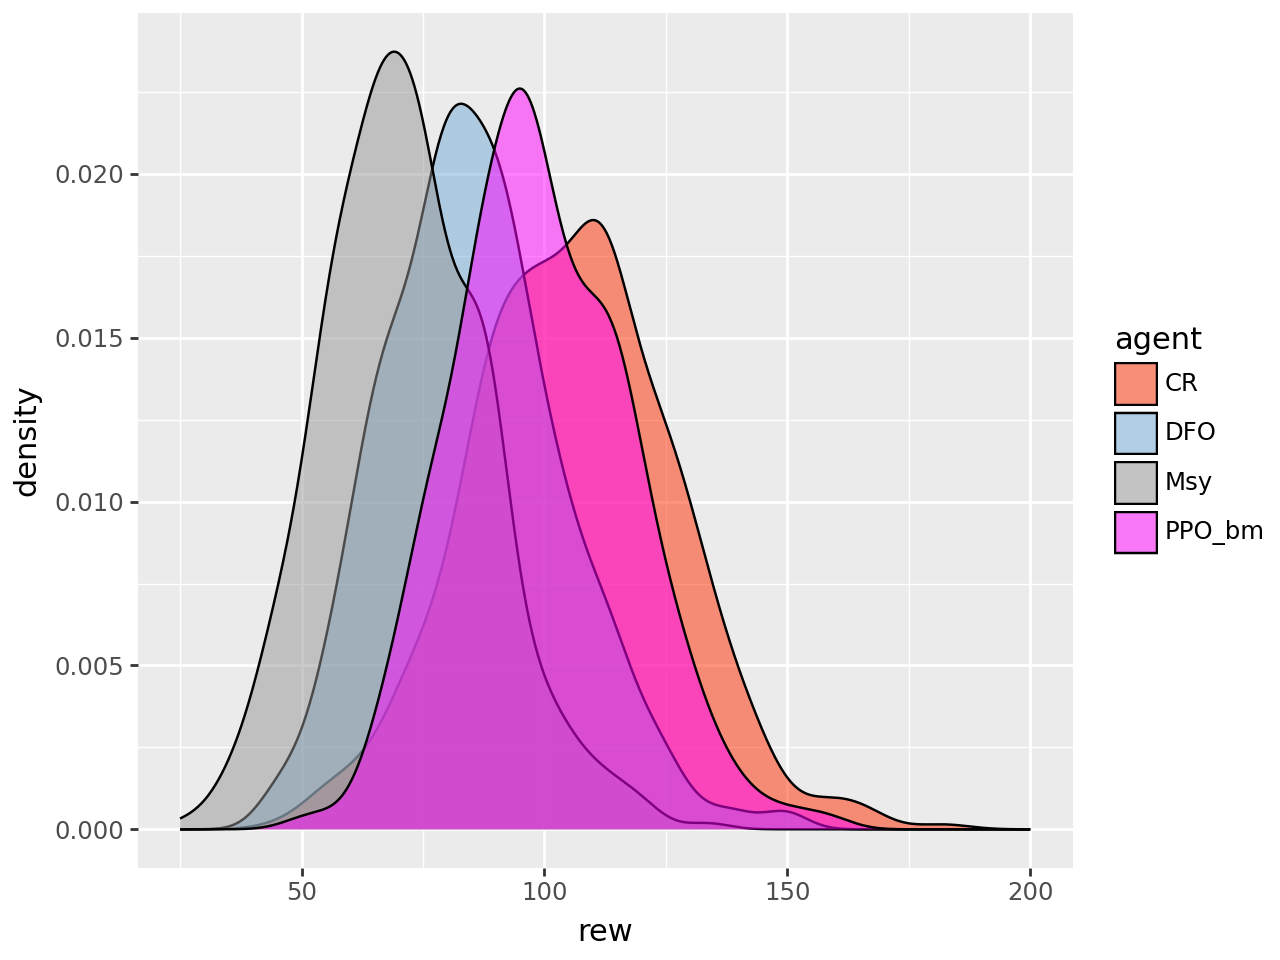

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


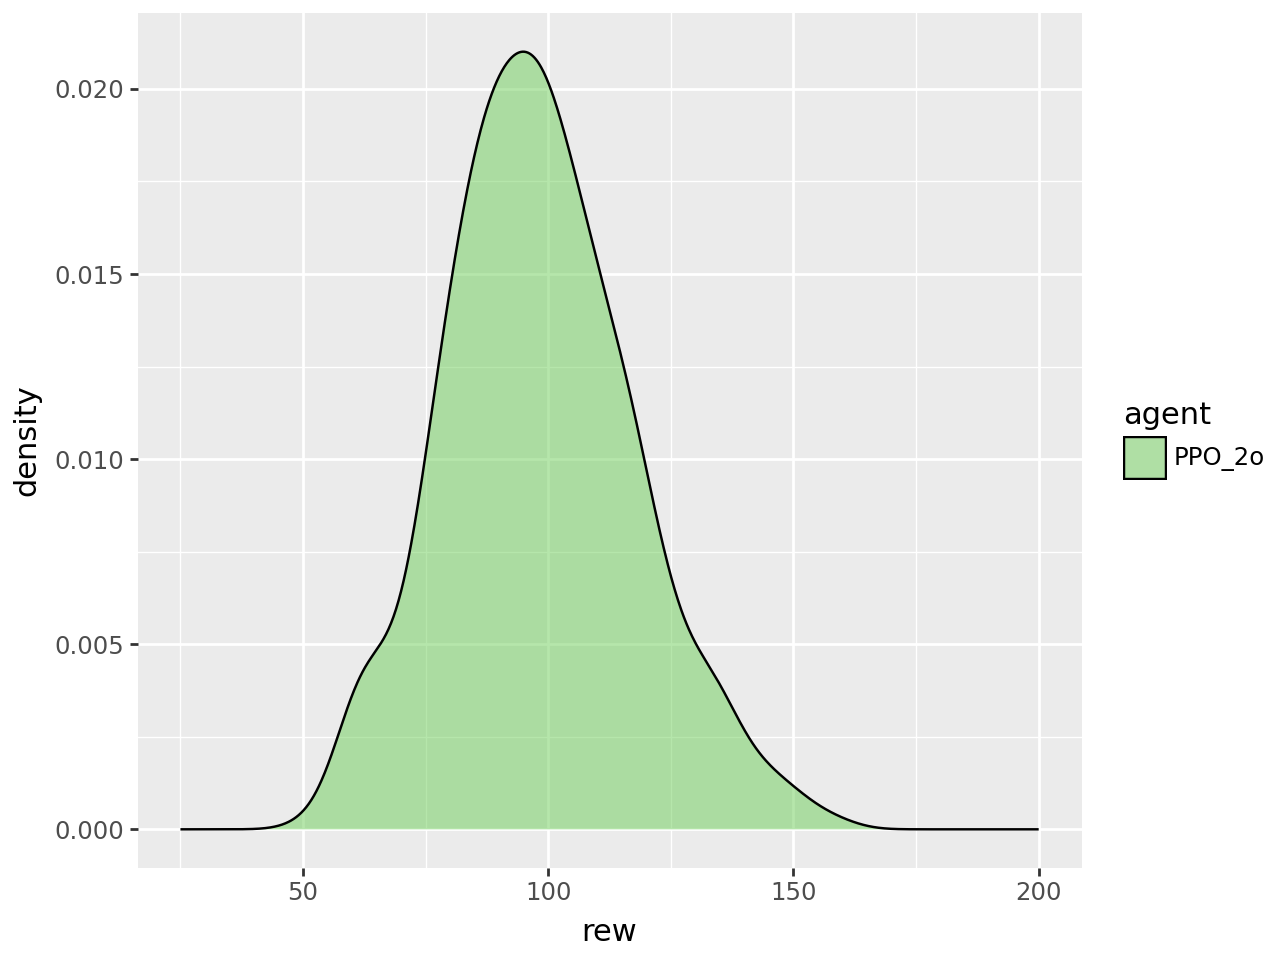

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [18]:
(
    (
        ggplot(
            UM1_results_df[UM1_results_df.agent != 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = other_hexs)
        + geom_density(alpha=0.5)
        + xlim(25, 200)
    ),
    (
        ggplot(
            UM1_results_df[UM1_results_df.agent == 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = ppo2o_hex)
        + geom_density(alpha=0.5)
        + xlim(25, 200)
    ),
)

### UM2

In [19]:
UM2_PPO_2o_rews = get_rews(
    agent=PPO_2o_UM2,
    env=AsmEnv(config=CFG_UM2_2o),
    agent_name='PPO_2o',
)

UM2_PPO_mw_rews = get_rews(
    agent=PPO_mw_UM2,
    env=AsmEnv(config=CFG_UM2_mw),
    agent_name='PPO_mw',
)

UM2_PPO_bm_rews = get_rews(
    agent=PPO_bm_UM2,
    env=AsmEnv(config=CFG_UM2_bm),
    agent_name='PPO_bm',
)


2024-08-20 09:44:43,709	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:45:00,057	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:45:16,384	INFO worker.py:1771 -- Started a local Ray instance.


In [20]:
UM2_CR_rews = get_rews(
    agent=PrecautionaryPrinciple(
        env=AsmEnv(config=CFG_UM2_bm),
        **(from_radius_theta(*cr_UM2.x)),
    ),
    env=AsmEnv(config=CFG_UM2_bm),
    agent_name='CR',
)

UM2_Esc_rews = get_rews(
    agent=ConstantEscapement(
        escapement=esc_UM2.x[0],
        env=AsmEnv(config=CFG_UM2_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM2_bm),
)

UM2_Msy_rews = get_rews(
    agent=FMsy(
        mortality=msy_UM2.x[0],
        env=AsmEnv(config=CFG_UM2_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM2_bm),
)

UM2_msy_step_rew = np.mean(UM2_Msy_rews['rew']) / 1000
UM2_fmsy = msy_UM2.x[0]
UM2_bmsy = UM2_msy_step_rew / UM2_fmsy

UM2_DFO = PrecautionaryPrinciple(
    env=AsmEnv(config=CFG_UM2_bm),
    x1 = 0.4 * UM2_bmsy,
    x2 = 0.8 * UM2_bmsy,
    y2 = UM2_fmsy,
)

UM2_DFO_rews = get_rews(
    agent=UM2_DFO,
    agent_name='DFO',
    env=AsmEnv(config=CFG_UM2_bm),
)

2024-08-20 09:45:32,732	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:45:41,005	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:45:49,160	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:45:57,475	INFO worker.py:1771 -- Started a local Ray instance.


In [21]:
UM2_bmsy

3.0976421316750975

In [22]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(UM2_CR_rews),
        pd.DataFrame(UM2_Esc_rews),
        pd.DataFrame(UM2_Msy_rews),
        pd.DataFrame(UM2_DFO_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(UM2_PPO_2o_rews),
        pd.DataFrame(UM2_PPO_mw_rews),
        pd.DataFrame(UM2_PPO_bm_rews),
    ]
)

UM2_results_df = pd.concat(
    [
        pd.DataFrame(UM2_CR_rews), 
        pd.DataFrame(UM2_Msy_rews),  
        pd.DataFrame(UM2_PPO_2o_rews), 
        pd.DataFrame(UM2_PPO_bm_rews),
        pd.DataFrame(UM2_DFO_rews),
    ]
)

In [23]:

print(f"""
UM2:

        mean stdev median
RPP:   {np.mean(UM2_CR_rews['rew']):.2f}, {np.std(UM2_CR_rews['rew']):.2f}, {np.median(UM2_CR_rews['rew']):.2f}, 
DFO:   {np.mean(UM2_DFO_rews['rew']):.2f}, {np.std(UM2_DFO_rews['rew']):.2f}, {np.median(UM2_DFO_rews['rew']):.2f}, 
Esc:  {np.mean(UM2_Esc_rews['rew']):.2f}, {np.std(UM2_Esc_rews['rew']):.2f}, {np.median(UM2_Esc_rews['rew']):.2f}, 
MSY:  {np.mean(UM2_Msy_rews['rew']):.2f}, {np.std(UM2_Msy_rews['rew']):.2f}, {np.median(UM2_Msy_rews['rew']):.2f}, 
PPO2: {np.mean(UM2_PPO_2o_rews['rew']):.2f}, {np.std(UM2_PPO_2o_rews['rew']):.2f}, {np.median(UM2_PPO_2o_rews['rew']):.2f},
PPO1: {np.mean(UM2_PPO_bm_rews['rew']):.2f}, {np.std(UM2_PPO_bm_rews['rew']):.2f}, {np.median(UM2_PPO_bm_rews['rew']):.2f},
""")


UM2:

        mean stdev median
RPP:   190.49, 29.58, 188.03, 
DFO:   94.55, 23.14, 93.90, 
Esc:  138.44, 24.85, 137.94, 
MSY:  174.40, 25.42, 174.20, 
PPO2: 134.16, 18.02, 133.69,
PPO1: 190.27, 27.79, 190.08,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/opt/venv/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 100 rows containing non-finite values.


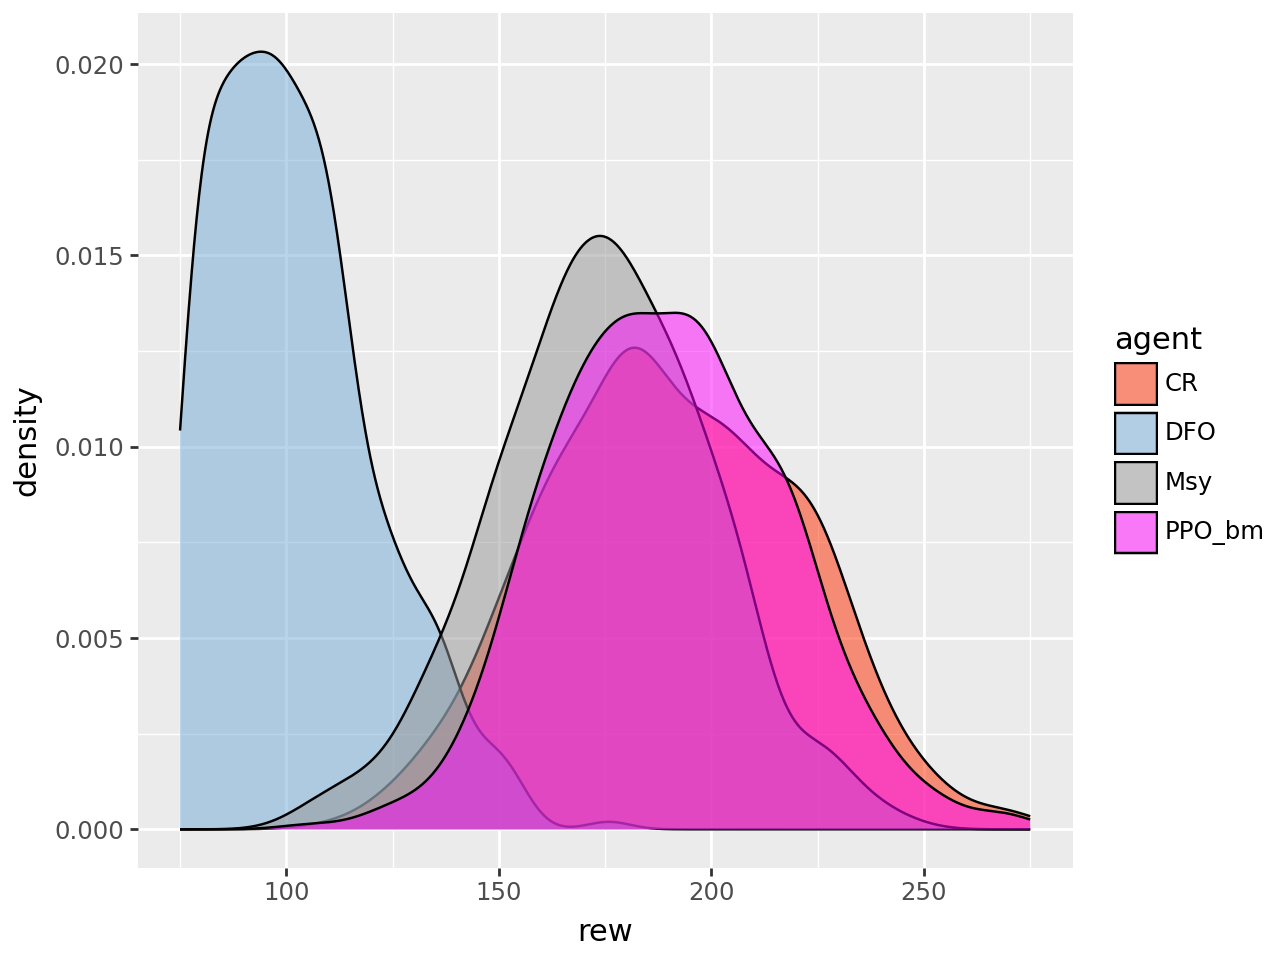

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


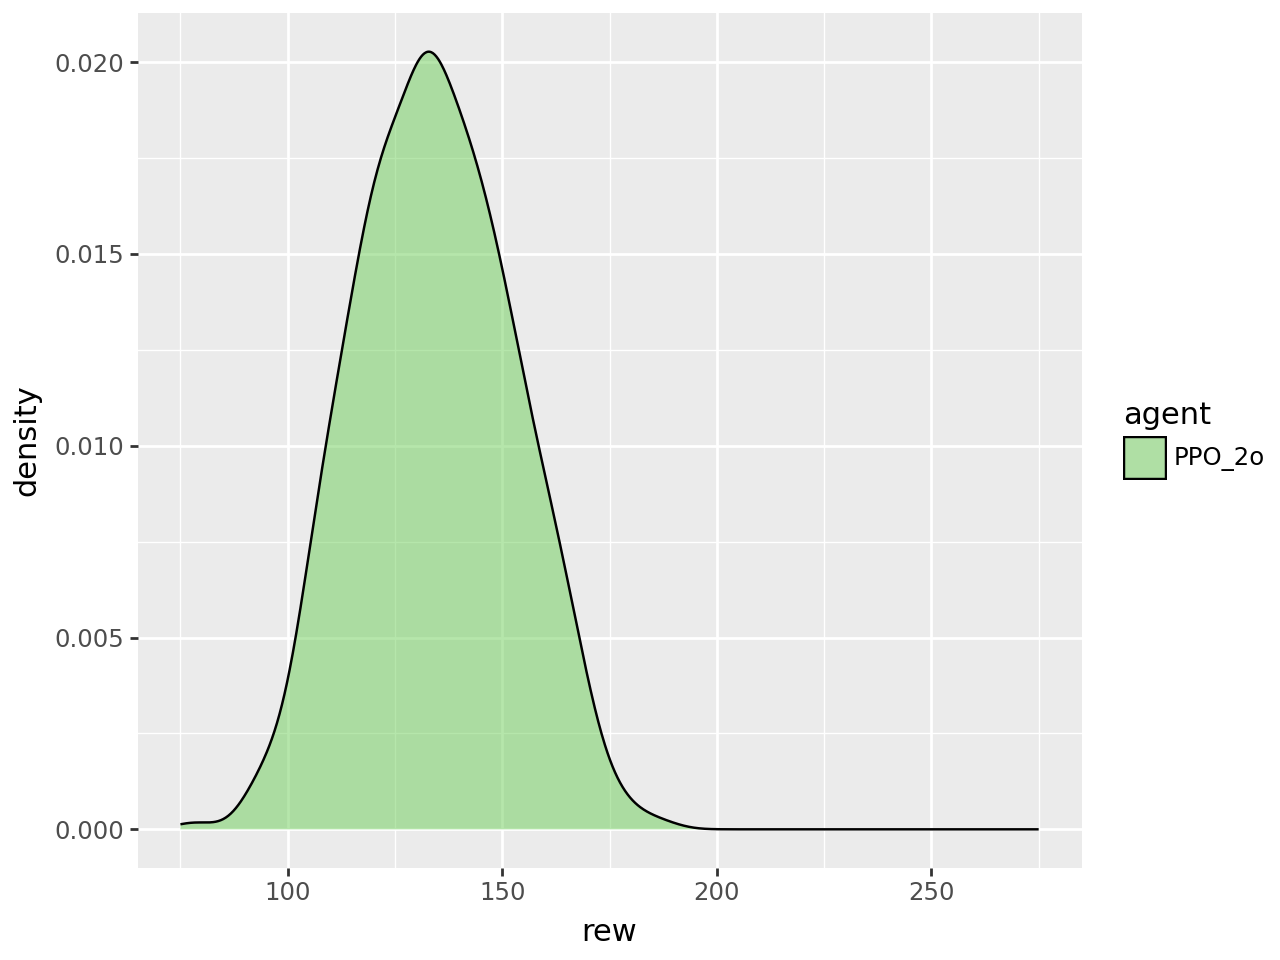

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [24]:
(
    (
        ggplot(
            UM2_results_df[UM2_results_df.agent != 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = other_hexs)
        + geom_density(alpha=0.5)
        + xlim(75, 275)
    ),
    (
        ggplot(
            UM2_results_df[UM2_results_df.agent == 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = ppo2o_hex)
        + geom_density(alpha=0.5)
        + xlim(75, 275)
    ),
)

### UM3

In [25]:
UM3_PPO_2o_rews = get_rews(
    agent=PPO_2o_UM3,
    env=AsmEnv(config=CFG_UM3_2o),
    agent_name='PPO_2o',
)

UM3_PPO_mw_rews = get_rews(
    agent=PPO_mw_UM3,
    env=AsmEnv(config=CFG_UM3_mw),
    agent_name='PPO_mw',
)

UM3_PPO_bm_rews = get_rews(
    agent=PPO_bm_UM3,
    env=AsmEnv(config=CFG_UM3_bm),
    agent_name='PPO_bm',
)


2024-08-20 09:46:06,133	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:46:22,416	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:46:38,330	INFO worker.py:1771 -- Started a local Ray instance.


In [26]:
UM3_CR_rews = get_rews(
    agent=PrecautionaryPrinciple(
        env=AsmEnv(config=CFG_UM3_bm),
        **(from_radius_theta(*cr_UM3.x)),
    ),
    env=AsmEnv(config=CFG_UM3_bm),
    agent_name='CR',
)

UM3_Esc_rews = get_rews(
    agent=ConstantEscapement(
        escapement=esc_UM3.x[0],
        env=AsmEnv(config=CFG_UM3_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM3_bm),
)

UM3_Msy_rews = get_rews(
    agent=FMsy(
        mortality=msy_UM3.x[0],
        env=AsmEnv(config=CFG_UM3_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM3_bm),
)

UM3_msy_step_rew = np.mean(UM3_Msy_rews['rew']) / 1000
UM3_fmsy = msy_UM3.x[0]
UM3_bmsy = UM3_msy_step_rew / UM3_fmsy

UM3_DFO = PrecautionaryPrinciple(
    env=AsmEnv(config=CFG_UM3_bm),
    x1 = 0.4 * UM3_bmsy,
    x2 = 0.8 * UM3_bmsy,
    y2 = UM3_fmsy,
)

UM3_DFO_rews = get_rews(
    agent=UM3_DFO,
    agent_name='DFO',
    env=AsmEnv(config=CFG_UM3_bm),
)

2024-08-20 09:46:54,209	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:47:02,519	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:47:10,779	INFO worker.py:1771 -- Started a local Ray instance.
2024-08-20 09:47:19,226	INFO worker.py:1771 -- Started a local Ray instance.


In [27]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(UM3_CR_rews),
        pd.DataFrame(UM3_Esc_rews),
        pd.DataFrame(UM3_Msy_rews),
        pd.DataFrame(UM3_DFO_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(UM3_PPO_2o_rews),
        pd.DataFrame(UM3_PPO_mw_rews),
        pd.DataFrame(UM3_PPO_bm_rews),
    ]
)

UM3_results_df = pd.concat(
    [
        pd.DataFrame(UM3_CR_rews), 
        pd.DataFrame(UM3_Msy_rews),  
        pd.DataFrame(UM3_PPO_2o_rews), 
        pd.DataFrame(UM3_PPO_bm_rews),
        pd.DataFrame(UM3_DFO_rews),
    ]
)

In [28]:
print(f"""
UM1:

        mean stdev median
RPP:   {np.mean(UM3_CR_rews['rew']):.2f}, {np.std(UM3_CR_rews['rew']):.2f}, {np.median(UM3_CR_rews['rew']):.2f}, 
DFO:   {np.mean(UM3_DFO_rews['rew']):.2f}, {np.std(UM3_DFO_rews['rew']):.2f}, {np.median(UM3_DFO_rews['rew']):.2f},
Esc:  {np.mean(UM3_Esc_rews['rew']):.2f}, {np.std(UM3_Esc_rews['rew']):.2f}, {np.median(UM3_Esc_rews['rew']):.2f}, 
FMSY:  {np.mean(UM3_Msy_rews['rew']):.2f}, {np.std(UM3_Msy_rews['rew']):.2f}, {np.median(UM3_Msy_rews['rew']):.2f}, 
PPO1: {np.mean(UM3_PPO_2o_rews['rew']):.2f}, {np.std(UM3_PPO_2o_rews['rew']):.2f}, {np.median(UM3_PPO_2o_rews['rew']):.2f},
PPO2: {np.mean(UM3_PPO_bm_rews['rew']):.2f}, {np.std(UM3_PPO_bm_rews['rew']):.2f}, {np.median(UM3_PPO_bm_rews['rew']):.2f},
""")


UM1:

        mean stdev median
RPP:   39.50, 7.98, 39.02, 
DFO:   38.22, 7.29, 37.56,
Esc:  17.57, 4.82, 17.59, 
FMSY:  35.59, 7.92, 35.41, 
PPO1: 79.21, 13.29, 78.05,
PPO2: 35.69, 7.39, 35.17,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/opt/venv/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 2 rows containing non-finite values.


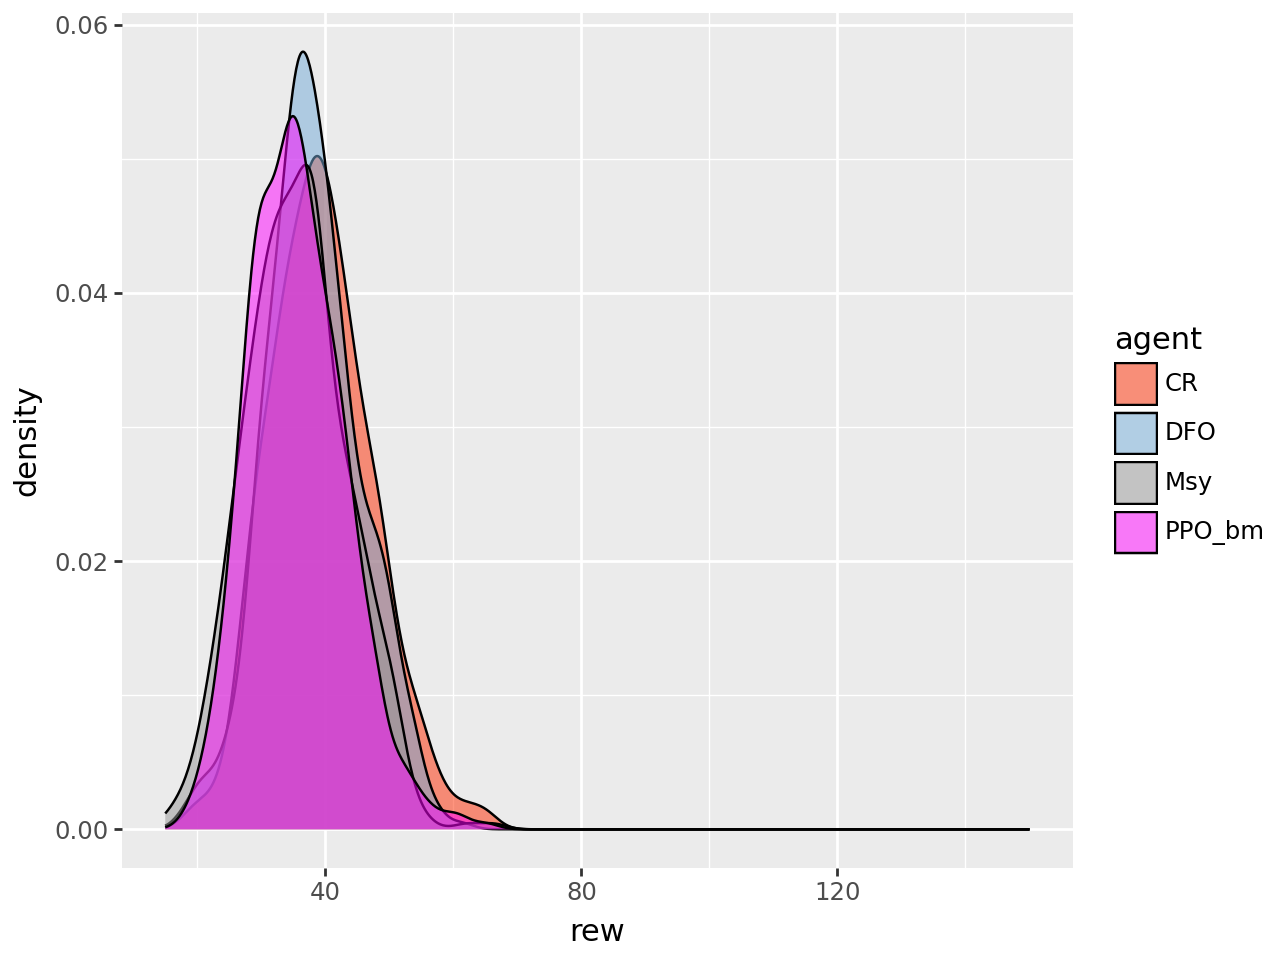

/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


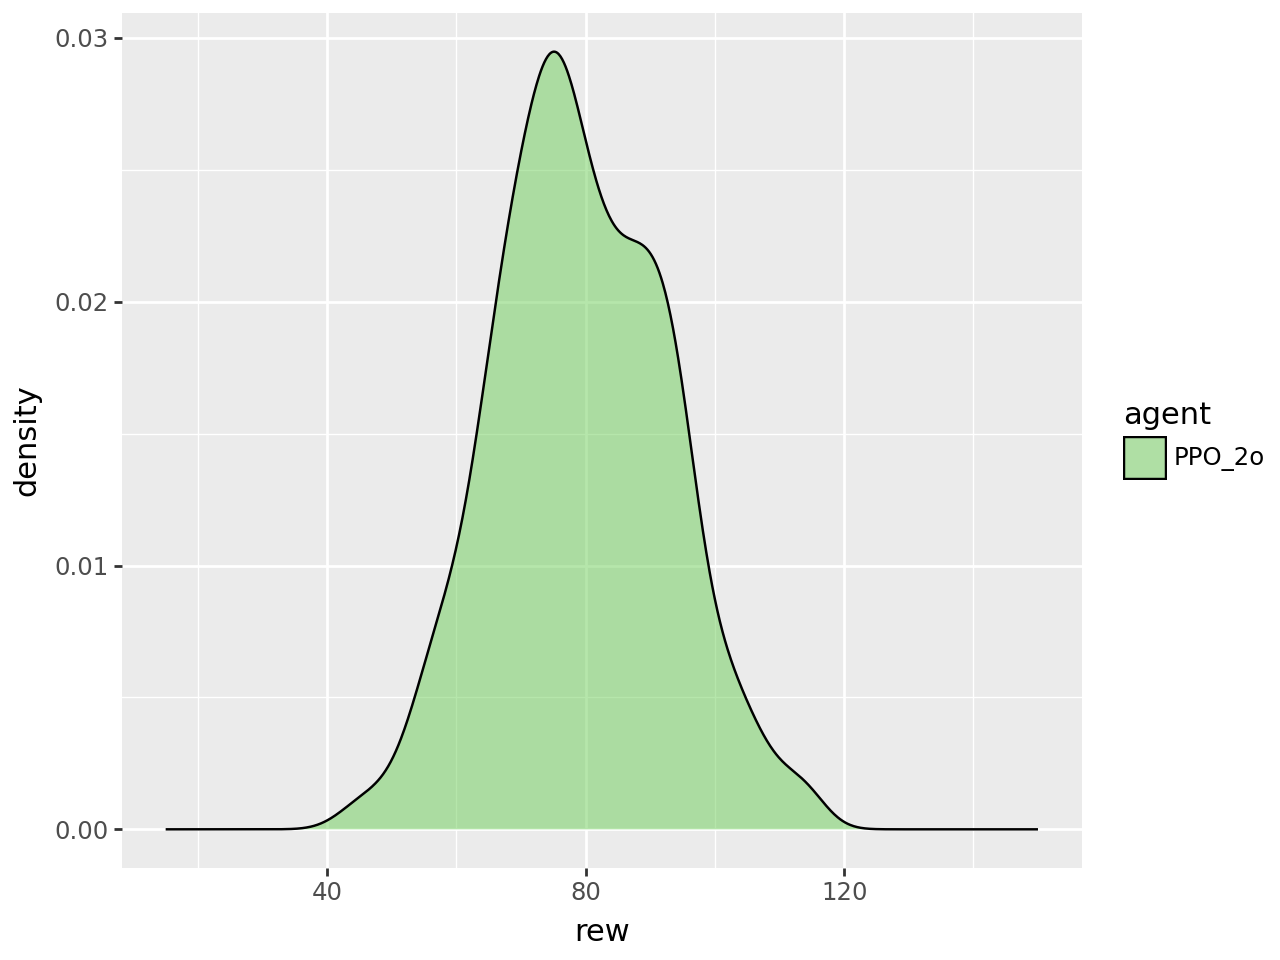

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [29]:
(
    (
        ggplot(
            UM3_results_df[UM3_results_df.agent != 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = other_hexs)
        + geom_density(alpha=0.5)
        + xlim(15, 150)
    ),
    (
        ggplot(
            UM3_results_df[UM3_results_df.agent == 'PPO_2o'], 
            aes(x='rew', fill='agent')
        ) 
        + scale_fill_manual(values = ppo2o_hex)
        + geom_density(alpha=0.5)
        + xlim(15, 150)
    ),
)